In [76]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from math import sqrt 
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold, train_test_split
import requests
from io import StringIO 
%matplotlib inline
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
ROOT = "/Users/kkalyan/github/airQo/"
train = pd.read_csv(ROOT+ "data/train-proc-v2.csv")
test = pd.read_csv(ROOT+ "data/test-proc-v2.csv")

In [5]:
test.drop("target",axis  = 1,inplace  = True)

In [6]:
from sklearn.preprocessing import LabelEncoder
lab  = LabelEncoder()

In [7]:
lab.fit(train["location"])

LabelEncoder()

In [8]:
train.location  = lab.transform(train.location)
test.location  = lab.transform(test.location)

In [9]:
X=train.drop(["ID",'target'],axis =1)
y = train.target

In [10]:
from catboost import CatBoostRegressor

In [16]:
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
fold=KFold(n_splits=20)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostRegressor(n_estimators=7000, eval_metric='RMSE',learning_rate=0.1, random_seed= 1234, use_best_model=True )
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100,)#erly100
    preds=m2.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m2.predict(test.drop(["ID"],axis = 1))
    y_pred_totcb2.append(p2)
np.mean(errcb2)

0:	learn: 41.1779056	test: 41.1779056	test1: 41.7155381	best: 41.7155381 (0)	total: 92.1ms	remaining: 10m 44s
100:	learn: 26.4907282	test: 26.4907282	test1: 28.4882525	best: 28.4882525 (100)	total: 4.85s	remaining: 5m 31s
200:	learn: 22.8702642	test: 22.8702642	test1: 26.4426130	best: 26.4426130 (200)	total: 9.58s	remaining: 5m 24s
300:	learn: 20.6967584	test: 20.6967584	test1: 25.8017993	best: 25.8002984 (299)	total: 15.4s	remaining: 5m 42s
400:	learn: 18.7677380	test: 18.7677380	test1: 25.2580405	best: 25.2580405 (400)	total: 21.5s	remaining: 5m 54s
500:	learn: 17.1169658	test: 17.1169658	test1: 24.9347188	best: 24.9341080 (499)	total: 26.2s	remaining: 5m 40s
600:	learn: 15.8260786	test: 15.8260786	test1: 24.6651048	best: 24.6651048 (600)	total: 31s	remaining: 5m 30s
700:	learn: 14.5177964	test: 14.5177964	test1: 24.3892850	best: 24.3892850 (700)	total: 36.6s	remaining: 5m 29s
800:	learn: 13.4162015	test: 13.4162015	test1: 24.1623265	best: 24.1623265 (800)	total: 42.2s	remaining: 5m 

24.074578663716895

In [56]:
k

,name,score
0,location,0.561861
1,newtemp0,0.641906
2,newprecip0,0.019020
3,newrel_humidity0,0.259565
4,newwind_dir0,0.030251
...,...,...
764,mean_atmos_press,2.103554
765,std_atmos_press,0.298663
766,var_atmos_press,0.194742
767,median_atmos_press,2.401576


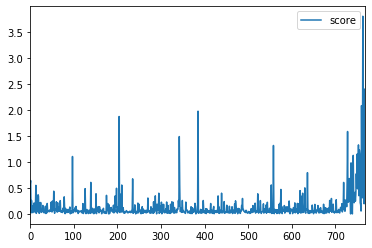

In [34]:
k = pd.DataFrame({"name": m2.feature_names_, "score": m2.feature_importances_})
k.plot()

In [84]:
m = k.sort_values(by="score", ascending=False)

In [17]:
from datetime import datetime
exp_time = str(datetime.now().replace(second=0, microsecond=0)).replace(" ", "_")
exp_name = "catboost-longer"
csv_file_name = "{}_{}".format(exp_time, exp_name)

In [18]:
test_id  = test['ID']
d = {'ID': test_id, 'target': np.mean(y_pred_totcb2, 0)}
sub = pd.DataFrame(data=d)
sub = sub[['ID', 'target']]

In [19]:
SUB = "/Users/kkalyan/github/airQo/submissions/"

In [20]:
sub.to_csv(SUB+csv_file_name+'.csv', index=False)